# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import time
from unityagents import UnityEnvironment
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define a longer timeout duration
timeout_duration = 60  # in seconds

# Launch the environment
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

# Wait for the environment to initialize
time.sleep(timeout_duration)

# Check if the environment is ready
try:
    env.reset()
except Exception as e:
    print("Unity environment failed to respond in time:", e)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.38993645 -1.5
 -0.          0.          6.83172083  5.99607611 -0.          0.        ]


### 3. Training the agent

In [4]:
from ddpg_agent import Group

group = Group(num_agents, state_size, action_size, 0)

In [5]:
def maddpg(n_episodes=2500, eps_start=1.0, eps_end=0.01, eps_decay=0.95):
    mdddpg_scores = []                 # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        group.reset()
        scores = np.zeros(num_agents)

        while True:
            actions = group.act(states, eps)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            group.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
        
        eps = max(eps_end, eps_decay*eps)
        episode_score = scores.max()
        scores_window.append(episode_score)
        mdddpg_scores.append(episode_score)
        avg_reward = np.mean(scores_window)
                
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, avg_reward), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, avg_reward))
        
        if avg_reward >= 0.5 and i_episode >= 100:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg_reward))
            torch.save(group.checkpoint(), 'agents.pth')
            break
        
    return mdddpg_scores


scores = maddpg()

/home/khanhnq79re/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	 Average Score: 0.00
Episode 200	 Average Score: 0.00
Episode 300	 Average Score: 0.00
Episode 400	 Average Score: 0.00
Episode 500	 Average Score: 0.00
Episode 600	 Average Score: 0.00
Episode 700	 Average Score: 0.01
Episode 800	 Average Score: 0.02
Episode 900	 Average Score: 0.01
Episode 1000	 Average Score: 0.02
Episode 1100	 Average Score: 0.01
Episode 1200	 Average Score: 0.01
Episode 1300	 Average Score: 0.06
Episode 1400	 Average Score: 0.15
Episode 1500	 Average Score: 0.14
Episode 1600	 Average Score: 0.20
Episode 1700	 Average Score: 0.28
Episode 1739	 Average Score: 0.51
Environment solved in 1739 episodes!	Average Score: 0.51


### 4. Plotting the scores

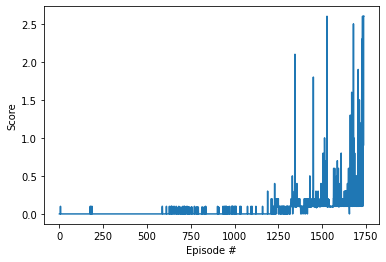

In [6]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('scores.png')
plt.show()

### 5. Watch a Smart Agent!

In [10]:
group = Group(num_agents, state_size, action_size, 0)
state_dict = torch.load('agents.pth')
for i, agent in enumerate(group.agents):
    agent.actor_local.load_state_dict(state_dict[i]['actor'])
    agent.critic_local.load_state_dict(state_dict[i]['critic'])

env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents)

while True:
    actions = group.act(states, 0)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += rewards
    states = next_states
    if np.any(dones):
        break

print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 1.845000027678907


In [11]:
env.close()